In [1]:
!nvidia-smi

Thu Jun  8 01:24:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
# Lets declare some components and hyper params
epochs = 5
lr = 1e-4
batch_size = 256

In [3]:
# Import your libraries
from PIL import Image
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt

<class 'numpy.ndarray'> (3000, 3000, 3)


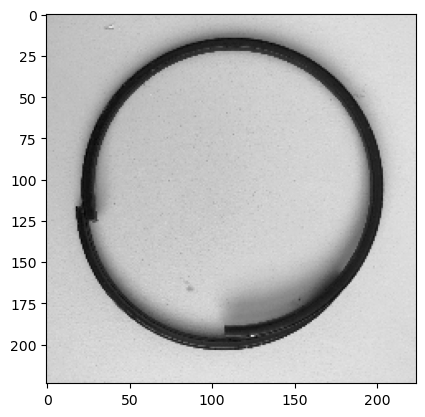

In [4]:
path = Path('/kaggle/input/glass-bangle-defect-detection-classification')
images_list = list(path.glob('**/*.jpg'))

img_cv = cv2.imread(str(images_list[0]))

print(type(img_cv), img_cv.shape)
# Resize img_cv -> 224 x 224
img_cv_resized = cv2.resize(img_cv, (224, 224))

# Change the color channel
img_cv_resized = cv2.cvtColor(img_cv_resized, cv2.COLOR_BGR2GRAY)
plt.imshow(img_cv_resized, cmap='gray')

# Lets import our module
- We need the following
    - Path finding libs
        - Pathlib
    - image manipulation library
        - PIL
        - cv2
    - Plotting libs
        - seaborn
        - maplotlib
    - data manipulation libs
        - Sklearn

In [5]:
# Path finder
from pathlib import Path
import os

# Image manipulation
import cv2
from PIL import Image
import numpy as np

# plotting libs
import seaborn as sns
from matplotlib import pyplot as plt

# Data manipulation
from sklearn.model_selection import train_test_split
from collections import Counter

In [6]:
# Lets define our path here
data_path = Path('/kaggle/input/glass-bangle-defect-detection-classification')
labels_map = {
    'defect': 0,
    'good': 1,
    'broken': 2
}
images_list = list(data_path.glob('**/*.jpg'))
labels = [img_p.parent.stem for img_p in images_list]

In [7]:
images_list[0]

PosixPath('/kaggle/input/glass-bangle-defect-detection-classification/dataset/defect/img5566.jpg')

# EDA (Explatory Data Analysis)
- We can explore our data here doing the following
    - Plot distribution of labels
    - Plot out some images to visualize

Text(0.5, 1.0, 'Label Distribution')

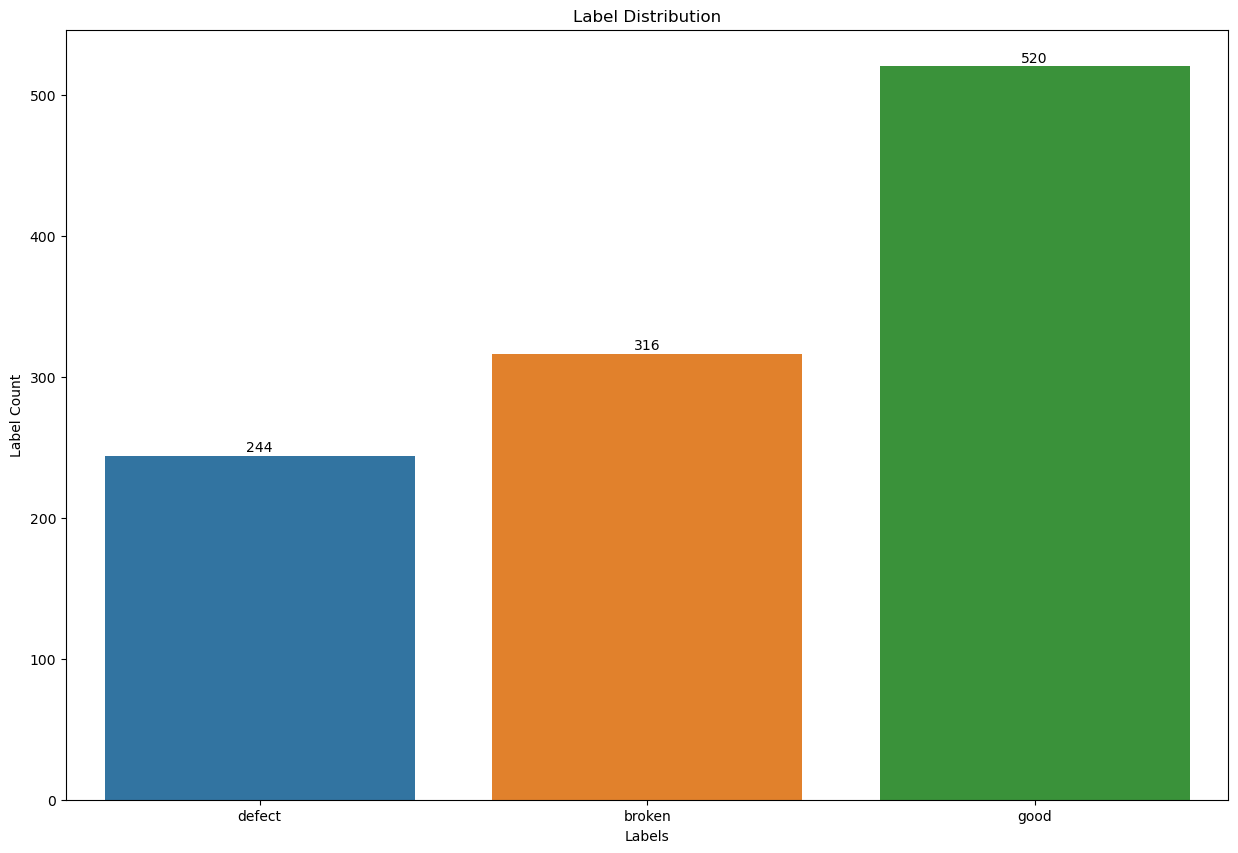

In [8]:
label_counts = Counter(labels)
total_lbls = [label for label, _ in label_counts.items()]
total_count = [count for _, count in label_counts.items()]

plt.figure(figsize=(15, 10))
sns.barplot(x=total_lbls, y=total_count)

# Add annotations
for i, v in enumerate(total_count):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Labels')
plt.ylabel('Label Count')
plt.title('Label Distribution')

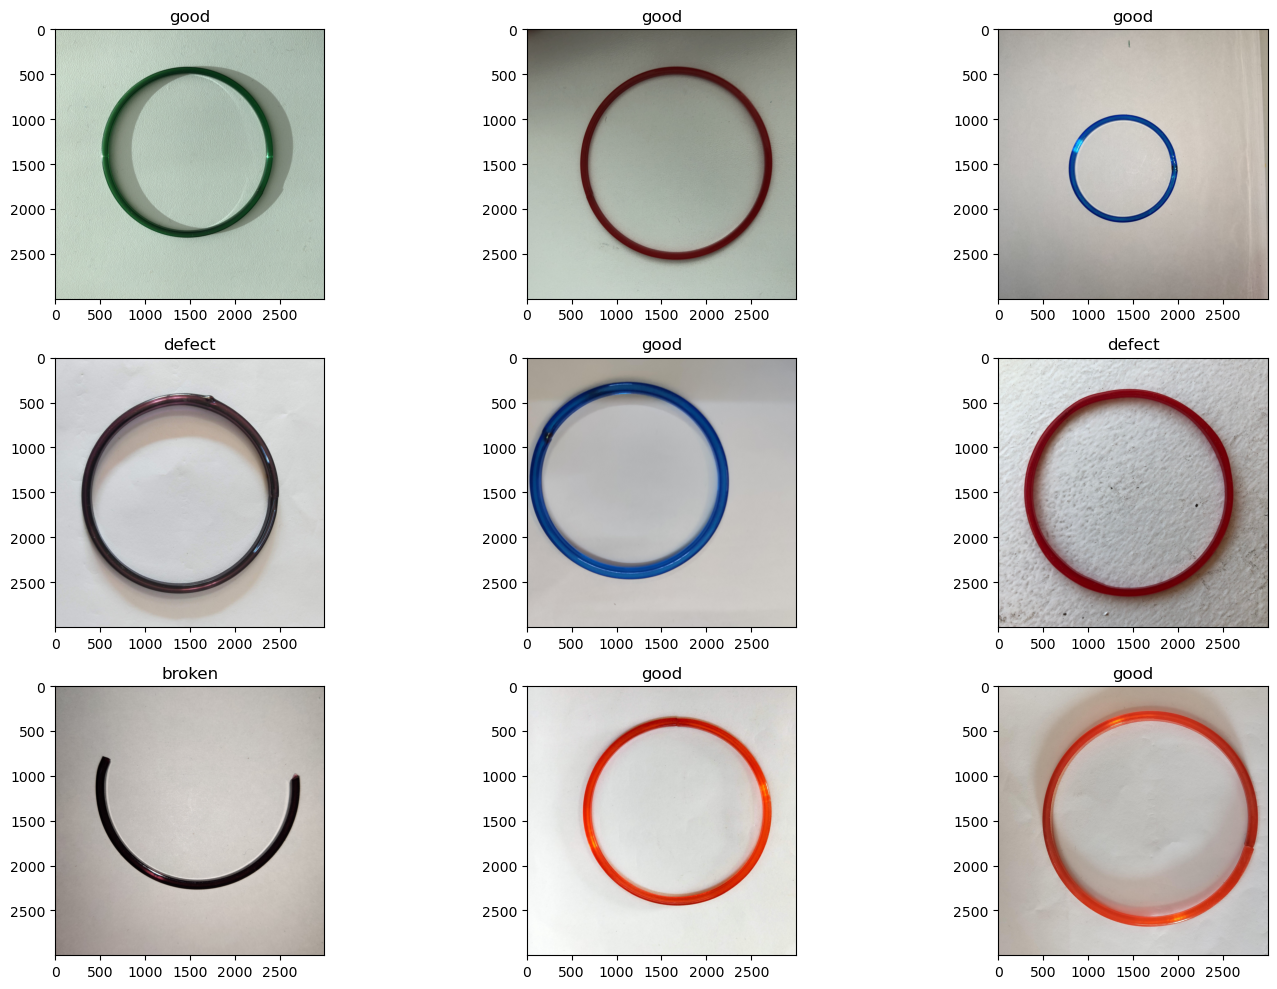

In [9]:
plt.figure(figsize=(15, 10))
index = 0
for sel_image in np.random.choice(images_list, 9):
    img = Image.open(str(sel_image))
    plt.subplot(3, 3, index + 1)
    plt.title(sel_image.parent.stem)
    plt.imshow(img)
    
    index += 1

plt.tight_layout()

# Lets split our dataset into the following groups
- train and test following the lables
- We use stratify to keep the distribution even

In [10]:
# Lets split the dataset
train_images, test_images, train_lbls, test_lbls = train_test_split(
    images_list, labels, 
    test_size=0.2, 
    random_state=2023, 
    stratify=labels
)

<Axes: title={'center': 'Test Dist Count'}>

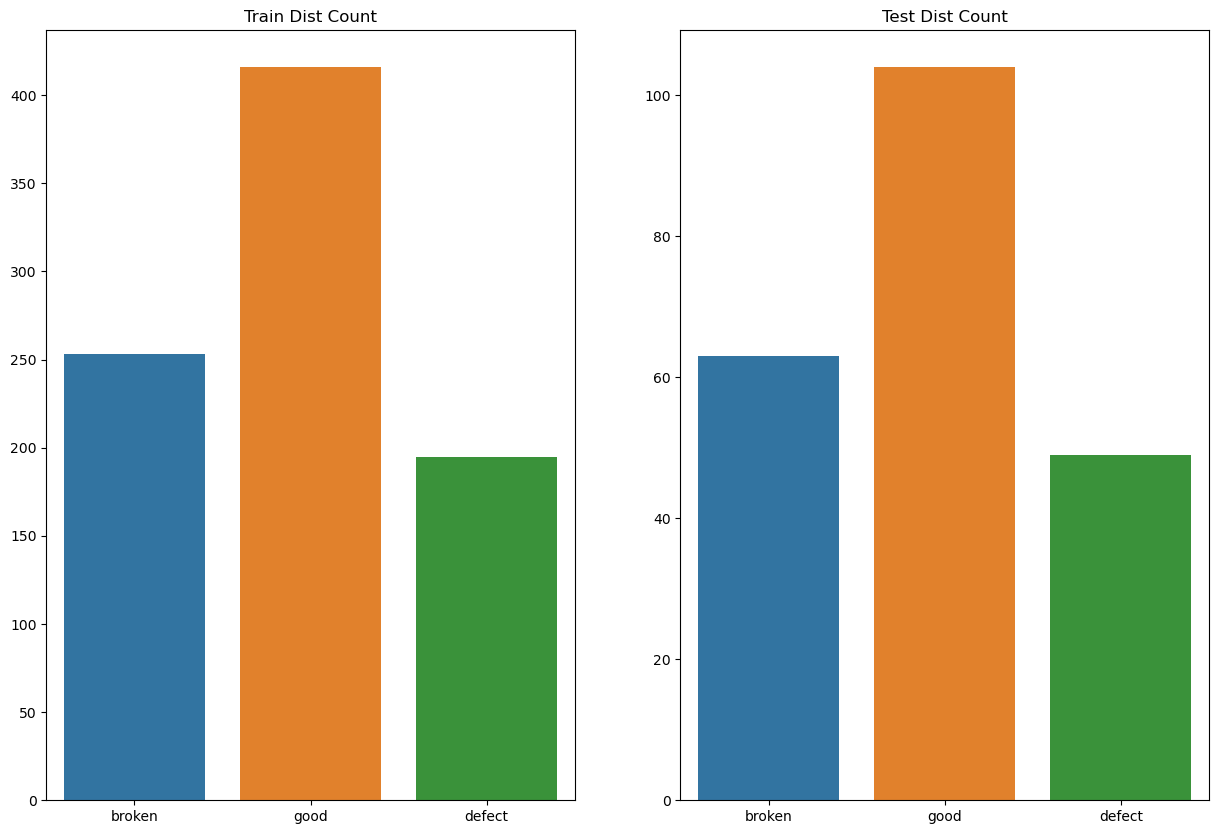

In [11]:
train_label_counts = Counter(train_lbls)
test_label_counts = Counter(test_lbls)

tst_count = []
tr_count = []
lbls = []
for tr_lbl, ts_lbl in zip(train_label_counts.items(), test_label_counts.items()):
    tr_count.append(tr_lbl[1])
    tst_count.append(ts_lbl[1])
    lbls.append(ts_lbl[0])
    
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Train Dist Count')
sns.barplot(x=lbls, y=tr_count)

plt.subplot(1, 2, 2)
plt.title('Test Dist Count')
sns.barplot(x=lbls, y=tst_count)

# # Add annotations
# for i, v in enumerate(total_count):
#     plt.text(i, v + 1, str(v), ha='center', va='bottom')

# # Set labels and title
# plt.xlabel('Labels')
# plt.ylabel('Label Count')
# plt.title('Label Distribution')

# Lets apply our torch modules here
- Using torchvision as a module we can apply our image transformations here
- Lets mix our dataset class along with our transform class
    - We can apply this via the getitem function

In [12]:
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

In [13]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])

In [15]:
img_pil = Image.open(train_images[0])
transform(img_pil).shape

torch.Size([3, 224, 224])

In [16]:
# Lets create a dataset class for bangle defect
class BangleDataset(Dataset):
    def __init__(self, images, labels, label_map, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.label_map = label_map
    
    def __len__(self):
        return len(self.images)
    
    # Handles the logic - processing logic
    def __getitem__(self, index):
        sel_img = self.images[index]
        
        # Image manipulation
        # Open as pil image
        img_pil = Image.open(sel_img).convert('RGB')    
        if self.transform is not None:
            img_pil = self.transform(img_pil)
            
        # Label manipulation
        sel_lbl = self.labels[index]
        sel_lbl = self.label_map[sel_lbl]
    
        return {
            'image': img_pil,
            'labels': sel_lbl
        }

In [17]:
train_dataset = BangleDataset(train_images, train_lbls, labels_map, transform)
test_dataset = BangleDataset(test_images, test_lbls, labels_map, transform)
next(iter(test_dataset))['image'].shape

torch.Size([3, 224, 224])

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
next(iter(test_dataloader))['image'].shape

torch.Size([216, 3, 224, 224])

# Lets start by building our model
- We can use the nn module
- We will build our cnn with the following moudles
    - Convolutional 2d Layer
    - Linear Layer

In [19]:
# Lets start by importing our modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large, resnet34

In [20]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

In [21]:
class BangleClassifier(nn.Module):
    def __init__(self, num_class=3) -> None:
        super(BangleClassifier, self).__init__()
        
#         self.backbone = mobilenet_v3_large(pretrained=True, progress=True)
#         self.backbone.classifier[-1] = nn.Linear(1280, num_class)
        self.backbone = resnet34(pretrained=True, progress=True)
        self.backbone.fc = nn.Linear(512, num_class)

        
    def forward(self, image):
        return self.backbone(image)

In [22]:
model = BangleClassifier()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 228MB/s]


In [23]:
with torch.no_grad():
    model(torch.randn(1, 3, 224, 224))

In [25]:
model;

# Lets use a third party lib
- torchmetrics (we can use this to measure our models)
- Accuracy is one of the most common metrics

In [26]:
!pip install torchmetrics

In [28]:
import random
from tqdm import tqdm
from torchmetrics import Accuracy

# Lets write our training loop
- Similar to yesterday we can use the following training loop style
    - Gather data
        - Move to GPU
    - Zero out gradients (Empty out your changes)
    - Run forward pass (Run prediction)
    - Run backward pass (update model)
    - Run evaluation metrics

In [30]:
# Declare our loss func
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Use device check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

# Lets use our accuracy metric class for both train and test
train_acc = Accuracy(task="multiclass", num_classes=3).to(device)
test_acc = Accuracy(task="multiclass", num_classes=3).to(device)

In [29]:
def training_step(batch):
    # Gather move our data to GPU
    image_tensor = batch['image'].to(device)
    label_tensor = batch['labels'].to(device)
    
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Run forward pass
    logits = model(image_tensor)
    
    # Run backward pass
    loss = criterion(logits, label_tensor)
    loss.backward()
    optimizer.step()
    
    # Run accuracy metrics
    train_acc(logits.argmax(dim=1), label_tensor)
    
    return loss.item()

def eval_step(batch):
    # Gather move our data to GPU
    image_tensor = batch['image'].to(device)
    label_tensor = batch['labels'].to(device)
    
    # Run forward pass
    with torch.no_grad():
        logits = model(image_tensor)
    
    # Compute loss
    loss = criterion(logits, label_tensor)
    
    # Run accuracy metrics
    test_acc(logits.argmax(dim=1), label_tensor)
    
    return loss.item()

In [31]:
for i in tqdm(range(epochs), desc='Epochs'):
    # Set to train mode
    model.train()
    train_loss = 0
    
    # Get our batch and run training step
    with tqdm(total=len(train_dataloader), desc='Running Train: {}'.format(i)) as pbar_train:
        for batch in train_dataloader:
            train_loss += training_step(batch)
            pbar_train.update(1)
        
    avg_train_loss = train_loss / len(train_dataloader)
        
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_dataloader), desc='Running Test: {}'.format(i)) as pbar_test:
            for batch in test_dataloader:
                eval_loss += eval_step(batch)
                pbar_test.update(1)
        
    avg_eval_loss = eval_loss / len(test_dataloader)
        
    print('Train Loss: {}'.format(avg_train_loss))
    print('Train Acc: {}'.format(round(train_acc.compute().item() * 100, 2)))

    print('Val Loss: {}'.format(avg_eval_loss))
    print('Val Acc: {}'.format(round(test_acc.compute().item() * 100, 2)))

Running Train: 0: 100%|██████████| 4/4 [01:49<00:00, 27.37s/it]

Epochs:  20%|██        | 1/5 [02:19<09:16, 139.18s/it]

Train Loss: 0.6384326666593552
Train Acc: 71.64
Val Loss: 0.5881121754646301
Val Acc: 75.93



Running Train: 1: 100%|██████████| 4/4 [01:31<00:00, 22.81s/it]

Epochs:  40%|████      | 2/5 [04:20<06:25, 128.54s/it]

Train Loss: 0.1916615627706051
Train Acc: 82.58
Val Loss: 0.7108127474784851
Val Acc: 75.23



Running Train: 2: 100%|██████████| 4/4 [01:42<00:00, 25.65s/it]

Epochs:  60%|██████    | 3/5 [06:32<04:20, 130.31s/it]

Train Loss: 0.12593547254800797
Train Acc: 87.15
Val Loss: 0.378654807806015
Val Acc: 78.24



Running Train: 3: 100%|██████████| 4/4 [01:43<00:00, 25.85s/it]

Epochs:  80%|████████  | 4/5 [08:45<02:11, 131.33s/it]

Train Loss: 0.05601231288164854
Train Acc: 90.02
Val Loss: 0.24122855067253113
Val Acc: 80.79



Running Train: 4: 100%|██████████| 4/4 [01:43<00:00, 25.92s/it]

Epochs: 100%|██████████| 5/5 [10:59<00:00, 131.83s/it]

Train Loss: 0.03931622067466378
Train Acc: 91.78
Val Loss: 0.22881187498569489
Val Acc: 82.22


# Inference (make a prediction)
- We can run the following seq
    - Load image as pil
    - transform to tensor
    - Run forward pass
    - map back to correct val
        - Run softmax to map logits to 0 -1 probability range
        - Get highest label index / Highest score
        
    - Show image along with label / conf / gt

100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


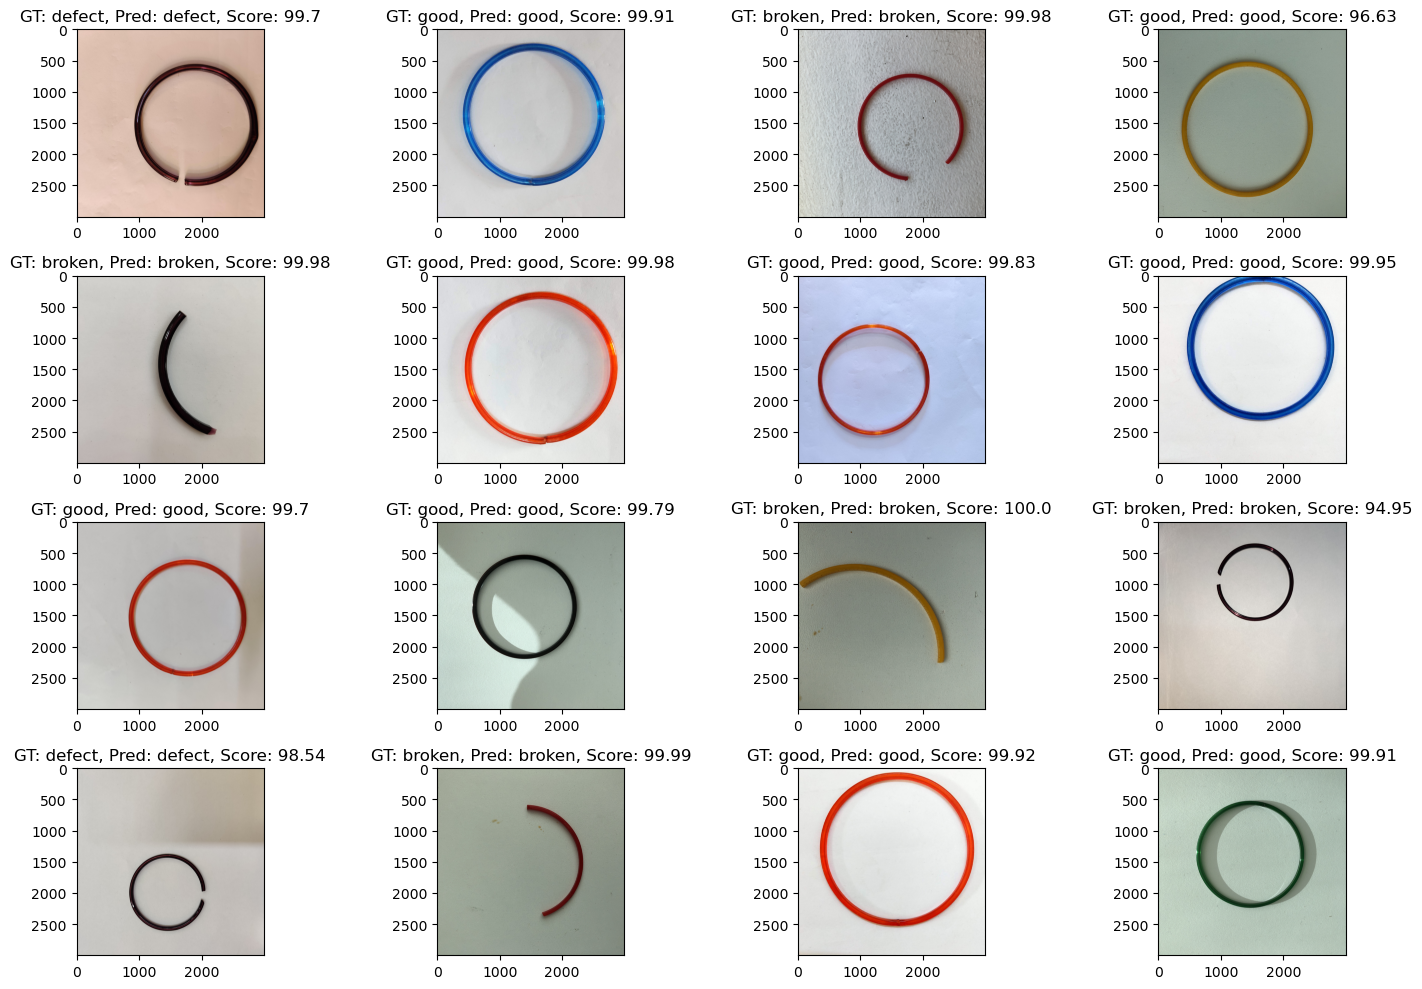

In [32]:
plt.figure(figsize=(15, 10))
index = 1
for sel_img in tqdm(random.sample(images_list, 16)):
    # Load image
    img_pil = Image.open(sel_img)
    gt_label = sel_img.parent.stem

    # Transform 
    img_tensor = transform(img_pil)
    img_tensor = img_tensor.unsqueeze(0)

    # Prediction
    with torch.no_grad():
        logits = model(img_tensor.to(device))
    
    # Map it back to a string
    labels = list(labels_map.keys())
    pred = F.softmax(logits, dim=1)
    
    pred_lbl = labels[pred[0].argmax().item()]
    pred_score = pred.max().item()
    
    plt.subplot(4, 4, index)
    plt.title('GT: {}, Pred: {}, Score: {}'.format(gt_label, pred_lbl, round(pred_score* 100, 2) ))
    plt.imshow(img_pil)
    
    index += 1 

plt.tight_layout()

In [ ]:
# Save Model 
torch.save(model.state_dict(), 'model_weights.pt')

In [ ]:
# Load back the model
model = BangleClassifier()
model.load_state_dict(torch.load('model_weights.pt'))

# Use model any way you like